### AlexNet

In the last tutorial we have learned how to build a simple convolutional neural network using the <code>tf.keras</code> API. In this tutorial we will look at a more complicated CNN, AlexNet, which won the 2012 ImageNet challenge and incorporated several innovative techniques for training a neural network. The original AlexNet structure was distributed on 2 GPUs due to memory constraints at that time. Here we build a simpler version that can be run on a single GPU today using the <code>tf.estimator</code> API, which is a high-level, but more flexible API. The architecture that we're going to build is as follows:

<img src="./files/AlexNet.png">

In [1]:
import tensorflow as tf

# Here, we turn on the eager execution mode. This enables us to evaluate or inspect 
# values of tf.Tensor variables immediately after we assign operations on them. 
# Traditionally this would not be possible because when we manipulate the tensors we
# are essentially building a computing graph. However, computation is never done until 
# we create a tf.Session instance to run the computation. With eager execusion, we can
# run the graph as soon as we manipulate the variables. This mode will serve as default
# in the forthcoming TensorFlow 2.0.
tf.enable_eager_execution()

print(tf.__version__)

1.12.0


### Implementing the <code>model_fn</code>

Estimator-based models are easily distributable on a multi-server environment, and can be run on CPUs, GPUs or TPUs without recoding the model. At the same time, it is high-level, meaning that you don't need to work with low-level TensorFlow APIs such as <code>tf.placeholder</code> and <code>tf.Variable</code>. 

When we talk about using <code>tf.estimator</code>, what we're really doing is building a <code>tf.estimator.Estimator</code> instance. This <code>Estimator</code> has methods that allow us to easily train, evaluate and export the model or to do predictions. The model itself should be wrapped in a model function, or <code>model_fn</code>, which will be supplied to the constructor of the <code>Estimator</code>. Therefore, we should build the model architecture in the <code>model_fn</code>.

The <code>model_fn</code> has a few key arguments:

<code>features</code>: the first item returned from <code>input_fn</code>, which contain features of our training instances. <code>input_fn</code> is the way by which we stream input data into the model, and we will talk about that later in this tutorial.

<code>labels</code>: the second item returned from <code>input_fn</code>, containing labels of our training instances. Both <code>features</code> and <code>labels</code> are either <code>tf.Tensor</code> instances or dictionaries of string feature/label names to <code>Tensor</code>.

<code>mode</code>: <code>tf.estimator.ModeKeys.TRAIN</code>, <code>tf.estimator.ModeKeys.EVAL</code>, or <code>tf.estimator.ModeKeys.PREDICT</code>. This is important because some steps are done differently in different modes. For example, dropout is only performed during training. 

What is returned from <code>model_fn</code> should be a <code>tf.estimator.EstimatorSpec</code> instance. This will tell the <code>Estimator</code> what loss function to optimize, what metrics to calculate, what algorithm to use for training, and how to generate predictions. Different arguments are required for different <code>ModeKeys</code>, which needs to be specified in the required <code>mode</code> argument. <code>TRAIN</code> also requires <code>loss</code> specifying the loss function and <code>train_op</code> specifying the training operation. <code>EVAL</code> only requires <code>loss</code>. And <code>PREDICT</code> requires <code>predictions</code>. Apart from these, there are other arguments by which you can do more things, including <code>eval_metric_ops</code>, which specifies different metrics to calculate. These will become clearere when we actually build the neural network.

Now we have come to the meat of implementing the model function. The flow is like this: we take training data from the <code>feature</code> argument, and pass it through different layers of the neural network. Each layer takes the output from the previous layer and produces output that can be fed into the next layer. After defining the model architecture, we define what predictions to make (classes or probabilities), how to calculate loss function, what optimizer to use and what metrics to evaluate. Then we return different <code>tf.estimator.EstimatorSpec</code> instances corresponding different values of the <code>mode</code> argument.

Here I'll make use of various types of functions available in TensorFlow. Layers are usually available in <code>tf.layers</code>, activation functions in <code>tf.nn</code>, loss functions in <code>tf.losses</code>, optimization algorithms in <code>tf.train</code>, and performance metrics in <code>tf.metrics</code>. Let's look at how this model function is constructed.

In [2]:
def model_fn(features, labels, mode):
    """Model function for AlexNet"""
    # 1. Input layer
    # The shape, by convention, should be [batch_size, height, width, channels].
    # Since batch size is not known yet, setting a size of -1 tells Tensorflow to
    # infer the size of that dimension when the data is actually available.
    input_layer = tf.reshape(features, [-1, 224, 224, 3])
    
    # 2. Convolutional layer 1
    # Takes input_layer as input. The other arguments are almost the same as what
    # we have seen in tf.keras. Here, the ReLU activation was used for the first
    # time. Deep neural networks with ReLU trains much faster than those with tanh
    # as the activation function.
    conv1 = tf.layers.conv2d(input_layer, filters=96, kernel_size=(11,11), strides=(4,4),
                             padding="valid", activation=tf.nn.relu)
    
    # 3. Local response normalization (LRN) 1
    # This is a new technique introduced in AlexNet. This normalization is done for 
    # each position across different feature maps. More details after this funcition
    # definition.
    lrn1 = tf.nn.lrn(conv1, depth_radius=5, bias=2, alpha=1e-4, beta=0.75)
    
    # 4. Max pooling layer 1
    # AlexNet used overlapping pooling with kernel size 3 by 3, and a stride of 2. 
    pool1 = tf.layers.max_pooling2d(lrn1, pool_size=(3,3), strides=(2,2), padding="valid")
    
    # 5. Convolutional layer 2
    # Here we use "same" padding and a stride of 1 to keep the dimension the same.
    conv2 = tf.layers.conv2d(pool1, filters=256, kernel_size=(5,5), strides=(1,1), 
                             padding="same", activation=tf.nn.relu)
    
    # 6. LRN 2
    lrn2 = tf.nn.lrn(conv2, depth_radius=5, bias=2, alpha=1e-4, beta=0.75)
    
    # 7. Max pooling layer 2
    pool2 = tf.layers.max_pooling2d(lrn2, pool_size=(3,3), strides=(2,2), padding="valid")
    
    # 8. Convolutional layer 3
    conv3 = tf.layers.conv2d(pool2, filters=384, kernel_size=(3,3), strides=(1,1), 
                             padding="same", activation=tf.nn.relu)
    
    # 9. Convolutional layer 4
    conv4 = tf.layers.conv2d(conv3, filters=384, kernel_size=(3,3), strides=(1,1), 
                             padding="same", activation=tf.nn.relu)
    
    # 10. Convolutional layer 5
    conv5 = tf.layers.conv2d(conv4, filters=256, kernel_size=(3,3), strides=(1,1), 
                             padding="same", activation=tf.nn.relu)
    
    # 11. Max pooling layer 3
    # The output of this layer will be [batch_size, 6, 6, 256].
    pool3 = tf.layers.max_pooling2d(conv5, pool_size=(3,3), strides=(2,2), padding="valid")
    
    # 12. Flatten
    # Remember that before piping the data into a dense layer we need to flatten all
    # dimensions except the first one which is batch_size.
    flatten = tf.layers.flatten(pool3)
    
    # 13. Dense layer 1
    # Similar to tf.keras, we need to specify the number of neurons and the activation
    # function.
    dense1 = tf.layers.dense(flatten, units=4096, activation=tf.nn.relu)
    
    # 14. Dropout 1
    # The dropout technique is also introduced in AlexNet. This is a technique of setting
    # to zero the output of each neuron with a certain probability in every training step.
    # This way, any neuron cannot rely on the presence of another neuron, so this is a
    # method to reduce overfitting of the model. Dropout is implemented as a layer to be put
    # after the output of a layer in Tensorflow, and we need to specify the probability of
    # dropping a neuron. Also, we only want dropout to happen during training, so we need
    # to provide whether the mode is tf.estimator.ModeKeys.TRAIN here.
    dropout1 = tf.layers.dropout(dense1, rate=0.5, training=(mode==tf.estimator.ModeKeys.TRAIN))
    
    # 15. Dense layer 2
    dense2 = tf.layers.dense(dropout1, units=4096, activation=tf.nn.relu)
    
    # 16. Dropout 2
    dropout2 = tf.layers.dropout(dense2, rate=0.5, training=(mode==tf.estimator.ModeKeys.TRAIN))
    
    # 17. Output layer
    # In the output layer, instead of calculating the probability distribution rendered by
    # the softmax function, we keep the logits without applying the softmax function. This is
    # because the logits will be easier to feed into the function for calculating the loss.
    # When we need the probabilities we can apply softmax to these logits. We'll look at the
    # code in later steps. For demonstration purposes we use an alternative binary
    # classification dataset instead of actual ImageNet data. Read more in the next section.
    logits = tf.layers.dense(dropout2, units=2)
    
    # Calculating prediction
    # For prediction, we want to know two things: first, what is the most likely category that 
    # the image belongs to, and second, what are the probabilites with which the image belongs
    # to each category. We create a dictionary with the name of these metrics as keys and their
    # values as values.
    predictions = {
        "classes": tf.argmax(input=logits, axis=1), # axis=0 is the batch_size
        "probabilities": tf.nn.softmax(logits=logits, name="softmax_tensor")} 
        # A name is created so that we can log this tensor.
    
    # If we are in PREDICT mode, we just return an EstimatorSpec with the predictions.
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # If we are not in PREDICT mode, we need to calculate the loss function. Since we're doing
    # multiclass classification, we will still use the sparse categorical crossentropy function.
    # However, in tf.losses there is only the sparse_softmax_cross_entropy function where you
    # need to supply the logits instead of the probabilities. That's why we didn't apply the
    # softmax function in the output layer.
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    # If we are in TRAIN mode, we also need to specify the optimizer to use and the training
    # operations. 
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(loss=loss, 
                                      global_step=tf.train.get_global_step()) 
        # This global_step variable is used by TensorFlow to track the number of training steps
        # that have been processed. Simply call tf.train.get_global_step() to obtain it.
        
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # If we are in EVAL mode, we also want to know the accuracy on the validation set. Therefore
    # we calculate it and add it as an eval_metric_ops.
    if mode == tf.estimator.ModeKeys.EVAL:
        accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
        eval_metric_ops = {"accuracy": accuracy}
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Implementing the <code>input_fn</code>

So now we have built the full neural network architecture and defined what operations to perform when we are training, evaluating or predicting with the model. However, we have not yet dealt with how to stream our input data into the model. When building a <code>tf.estimator</code> model, the input data is processed with an input function, or <code>input_fn</code>. This function should return a <code>tf.data.Dataset</code> of batches of <code>(features, labels)</code>, where <code>features</code> is a dictionary from feature names to <code>tf.Tensor</code> containing batches of features, and <code>labels</code> is a <code>tf.Tensor</code> containing batches of labels. Let's look at how to implement this with code.

Since the ImageNet dataset is huge, I've chosen an alternative dataset of images of dogs and cats, and our task is to classify images into these two categories. The data can be downloaded here: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data. The training set contains 25,000 images of cats and dogs. First of all, we need to do some preprocessing so that the input conforms to our input format of 224 by 224 by 3.

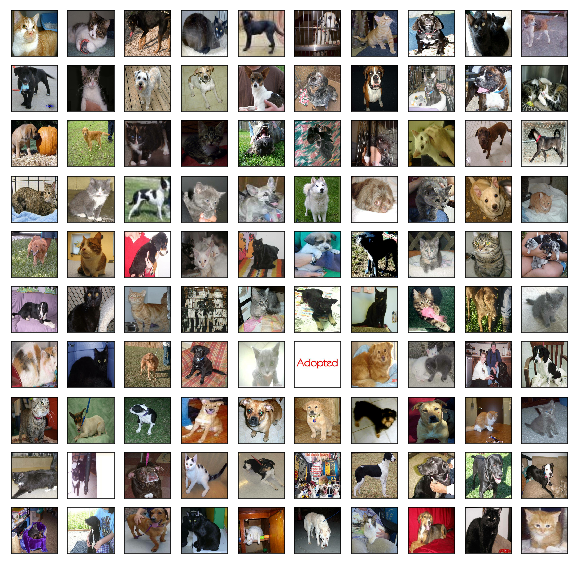

In [3]:
import glob
import random
from matplotlib import pyplot as plt
%matplotlib inline

# We're going to do minimum preprocessing. For simiplicity, we will resize the image into 224 
# pixels by 224 pixels. And then we're just going to convert it into RGB format. Let's take a
# look at a sample of the images in the training set.

TRAINING_PATH = "./datasets/dogs_vs_cats/train/" # Replace with your training image folder
image_files = glob.glob(TRAINING_PATH + "*.jpg")
image_sample = random.sample(image_files, 100) # Take a sample of 100 images.
processed_sample = []

for image_file in image_sample:
    img = tf.read_file(image_file)
    
    # Decode the jpg file; channels=3 indicates RGB encoding.
    img = tf.image.decode_jpeg(img, channels=3) 
    # Resize into 224 by 224.0
    img = tf.image.resize_images(img, [224, 224])
    # Normalize so that values are between 0 and 1.
    img /= 255.0
    processed_sample.append(img)

fig, ax = plt.subplots(10,10)
fig.set_figwidth(10)
fig.set_figheight(10)
for i in range(100):
    ax[i//10][i%10].imshow(processed_sample[i])
    ax[i//10][i%10].set_xticks([])
    ax[i//10][i%10].set_yticks([])

The <code>tf.data.Dataset</code> API is a powerful tool for generating batched input for neural networks from a variety types of source data. Here, we will create a <code>tf.data.Dataset</code> by providing two lists, one containing all the file names, and the second containing the corresponding labels. Then, we will use the <code>Dataset.map()</code> method to preprocess every image in the dataset with the same steps, transforming the dataset to one containing the actual images and labels. 

In [4]:
filenames = glob.glob(TRAINING_PATH + "*.jpg")

# Label is 1 for dogs and 0 for cats.
labels = [1 if f.split('/')[-1].split('.')[0] == 'dog' else 0 for f in filenames]

print("First 3 image files:", filenames[:3])
print("First 3 image labels:", labels[:3])

First 3 image files: ['./datasets/dogs_vs_cats/train/cat.0.jpg', './datasets/dogs_vs_cats/train/cat.1.jpg', './datasets/dogs_vs_cats/train/cat.10.jpg']
First 3 image labels: [0, 0, 0]


In [5]:
# Create a tf.data.Dataset instance from these tf.Tensors.

# We provide a tuple of tensors to the from_tensor_slices().
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# Then, we can define a function to preprocess images from their filenames.
# In this way, we can transform this dataset into a dataset of tf.Tensors
# representing the image data and labels.
def preprocess_image(filename, label):
    img = tf.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3) # Decode into RGB.
    img = tf.image.resize_images(img, [224, 224]) # Resize into 224 by 224.
    img /= 255.0 # Normalize.
    return img, label

dataset = dataset.map(preprocess_image)

dataset # We're not actually going to use this. Clear some memory.

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int32)>

Now we are ready to write our input functions for training, evaluation and testing. The input function will take in a list of filenames and a list of corresponding labels, as well as a batch_size argument to specify the batch size. One thing to note is that the <code>input_fn</code> to be supplied to the estimator expects no arguments. Therefore we typically wrap the actual input function with a wrapper function that takes all the arguments, builds and returns the input function. 

In [6]:
def input_fn_builder(filenames, labels, batch_size):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
        dataset = dataset.map(preprocess_image)
        
        # We can shuffle the dataset with a speficied buffer size.
        dataset = dataset.shuffle(buffer_size=20000)
        
        # We can batch the data with speficied batch size. In each training step,
        # a batch will be generated from this dataset. The repeat method can
        # repeat the dataset indefinitely so we can train for multiple epochs.
        return dataset.repeat().batch(batch_size=batch_size)
    
    # Returns the input function with no arguments.
    return input_fn

In [7]:
# Now we can split all our training data into a training set and a validation set.
# We can use 80% of the data for training and 20% for validation.

eval_filenames = random.sample(image_files, int(len(image_files) * 0.2))
eval_labels = [1 if f.split('/')[-1].split('.')[0] == 'dog' else 0 for f in eval_filenames]

train_filenames = [f for f in image_files if f not in eval_filenames]
train_labels = [1 if f.split('/')[-1].split('.')[0] == 'dog' else 0 for f in train_filenames]

print("Number of images in the training set:", len(train_filenames))
print("Number of images in the validation set:", len(eval_filenames))

Number of images in the training set: 20000
Number of images in the validation set: 5000


In [8]:
# Now, we can create one input function for the training set and one for the validation set.
# We choose a batch size of 128 images. This way, 1 epoch requires around 160 training steps.

train_input_fn = input_fn_builder(train_filenames, train_labels, batch_size=128)
eval_input_fn = input_fn_builder(eval_filenames, eval_labels, batch_size=128)

### Training and evaluating the model

We are now ready to train our model. Estimators provide an easy way to do this. It has a <code>train()</code> method that allows us to train the model. We need to provide with it the <code>input_fn</code>, and the number of training steps to perform. Let's train the model for around 10 epochs, which translates to roughly 1600 steps.

But first, we need to create the model. This is easily done by providing the <code>tf.estimator.Estimator</code> constructor with our <code>model_fn</code>. And we also want to provide a directory for saving the initialized model and trained models.

In [9]:
model = tf.estimator.Estimator(model_fn=model_fn, model_dir="./tmp/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './tmp/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f304d3689b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [10]:
# Now we train the model for 1600 steps.

model.train(input_fn=train_input_fn, steps=1600)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./tmp/model.ckpt.
INFO:tensorflow:loss = 0.69403255, step = 0
INFO:tensorflow:global_step/sec: 3.60977
INFO:tensorflow:loss = 0.6929023, step = 100 (27.709 sec)
INFO:tensorflow:global_step/sec: 1.6799
INFO:tensorflow:loss = 0.6932, step = 200 (59.525 sec)
INFO:tensorflow:global_step/sec: 3.77031
INFO:tensorflow:loss = 0.693431, step = 300 (26.525 sec)
INFO:tensorflow:global_step/sec: 1.68393
INFO:tensorflow:loss = 0.69200337, step = 400 (59.383 sec)
INFO:tensorflow:global_step/sec: 1.63146
INFO:tensorflow:loss = 0.6912873, step = 500 (61.296 sec)
INFO:tensorflow:global_step/sec: 3.695
INFO:tensorflow:loss = 0.6939266, step = 600 (27.062 sec)
INFO:tensorflow:global_step/sec: 1.73167
INFO:tensorflow:loss = 0.6

Now that we have trained the model, let's take a look at the performance of our model on the validation set. To do this, we can call the <code>evaluate</code> method of the estimator. This time, we need to provide it with <code>eval_input_fn</code>. We just evaluate for 39 steps since that will cover most of the data from the valiation set.

In [11]:
model.evaluate(input_fn=eval_input_fn, steps=39)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-01-03:54:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt-1600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [3/39]
INFO:tensorflow:Evaluation [6/39]
INFO:tensorflow:Evaluation [9/39]
INFO:tensorflow:Evaluation [12/39]
INFO:tensorflow:Evaluation [15/39]
INFO:tensorflow:Evaluation [18/39]
INFO:tensorflow:Evaluation [21/39]
INFO:tensorflow:Evaluation [24/39]
INFO:tensorflow:Evaluation [27/39]
INFO:tensorflow:Evaluation [30/39]
INFO:tensorflow:Evaluation [33/39]
INFO:tensorflow:Evaluation [36/39]
INFO:tensorflow:Evaluation [39/39]
INFO:tensorflow:Finished evaluation at 2019-04-01-03:54:21
INFO:tensorflow:Saving dict for global step 1600: accuracy = 0.60857373, global_step = 1600, loss = 0.65990674
INFO:tensorflow:Saving 'checkpoint_path' summary for global st

{'accuracy': 0.60857373, 'loss': 0.65990674, 'global_step': 1600}

We see that the accuracy is better than random guessing. Training for more epochs and adjusting learning hyperparameters such as the learning rate may give you better performance. Finally, we can try to make predictions on the test set by calling the <code>predict</code> method. Here, we also need to provide an input function. We write another input function builder to do this. The only difference would be that we don't have labels for the data. Also, we don't want to repeat the test set to generate more batches. We only want to predict once for each image. Therefore we remove the repetition operation for the dataset.

In [12]:
TEST_PATH = "./datasets/dogs_vs_cats/test/" # Replace with your test image folder
test_image_files = glob.glob(TEST_PATH + "*.jpg")

def preprocess_test_image(filename):
    img = tf.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize_images(img, [224, 224])
    img /= 255.0
    return img

def pred_input_fn_builder(filenames, batch_size):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((filenames))
        dataset = dataset.map(preprocess_test_image)
        dataset = dataset.shuffle(buffer_size=5000)
        return dataset.batch(batch_size=batch_size) # Removed 'repeat'.
    return input_fn

pred_input_fn = pred_input_fn_builder(test_image_files, batch_size=128)

predictions = []
for pred in model.predict(pred_input_fn):
    predictions.append(pred)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt-1600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [13]:
# Check the first 10 predictions in the test set.
predictions[:10]

[{'classes': 0,
  'probabilities': array([0.51647556, 0.48352447], dtype=float32)},
 {'classes': 0,
  'probabilities': array([0.56552577, 0.43447417], dtype=float32)},
 {'classes': 0,
  'probabilities': array([0.51918817, 0.48081183], dtype=float32)},
 {'classes': 0,
  'probabilities': array([0.6499882 , 0.35001186], dtype=float32)},
 {'classes': 0,
  'probabilities': array([0.5792052 , 0.42079476], dtype=float32)},
 {'classes': 1,
  'probabilities': array([0.42669246, 0.5733075 ], dtype=float32)},
 {'classes': 0,
  'probabilities': array([0.61747164, 0.38252836], dtype=float32)},
 {'classes': 0,
  'probabilities': array([0.5734723 , 0.42652768], dtype=float32)},
 {'classes': 0,
  'probabilities': array([0.5363993 , 0.46360072], dtype=float32)},
 {'classes': 1,
  'probabilities': array([0.45757055, 0.5424295 ], dtype=float32)}]

Here we have learned the basics of using the <code>tf.estimator</code> API for building a model and using the <code>tf.data.Dataset</code> API for managing inputs to the model. However, there are a lot of other powerful features, e.g. saving checkpoints during training and starting training from existing checkpoints. We will look into these features in the following tutorials.